# Market research

__Full Pre-processing and training pipeline, by Chihebeddine HAMMAMI__

## Setup

In [0]:
import os

import numpy as np
import pandas as pd

# For DataViz
import matplotlib.pyplot as plt
import seaborn as sns

import re # For text handling

# For training ML algorithms

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder


# To render plots inside notebooks
%matplotlib inline

In [0]:
# Files parameters
PATH = './../data/raw/'
TRAIN_FILE_NAME = "mower_market_snapshot.csv"
TEST_FILE_NAME = "submission_set.csv"
FIGS_PATH = './../figs'
TRAINING_TEST_RATIO = 0.2

# Pipeline parameters
num_imputer_strategy = "median"
cat_imputer_strategy = "most_frequent"

# Numerical features
num_columns = ['capacity','failure_rate', 'margin',
               'price', 'prod_cost', 'warranty', 'attractiveness']


## Full pre-processing pipeline

In [0]:
def get_data(path, file_name):
    """
    Reads csv file
    
    """
    file_path = os.path.join(path, file_name)
    df = pd.read_csv(filepath_or_buffer = file_path, sep = ';')
    return df

def parse_warranty(x):
    """
    parse warranty string format
    """
    m = re.search('^[0-9]+',x)
    return float(m.group(0))

def pre_process(df):
    """
    Perform custom pre-processing tasks to transform df 
    """
    # Set index
    df_trans = df.set_index('id')

    # Coerce to numeric values if possible otherwise return np.nan
    df_trans["prod_cost"] = pd.to_numeric(df_trans["prod_cost"], "coerce")

    # Handle warranty column diverse formats
    df_trans["warranty"] = df_trans["warranty"].apply(parse_warranty)

    # Correct `quality` typo from Hight to High
    df_trans.quality = df_trans.quality.apply(lambda x: 'High' if x.lower() =="hight" else x)

#     # Handle floating precision at display round at 3 decimal digits
#     df_trans.loc[:,num_columns] = df_trans.loc[:,num_columns].applymap(lambda x: round(x,3))

    # drop `market_share`
    if "market_share" in df_trans.columns :
        df_trans.drop(labels = "market_share",
                   axis = 1,
                   inplace = True)
    else:
        pass
    return df_trans

In [0]:
raw_mower_data_train = get_data(PATH,TRAIN_FILE_NAME)
raw_mower_data_test = get_data(PATH,TEST_FILE_NAME)

In [0]:
# Train test split
# Startified Training/test split based on `product_type`
spliter = StratifiedShuffleSplit(n_splits=1, test_size=TRAINING_TEST_RATIO, random_state = 42)
for train_index, test_index in spliter.split(raw_mower_data_train, raw_mower_data_train["product_type"]):
    strat_train_set = raw_mower_data_train.iloc[train_index]
    strat_test_set = raw_mower_data_train.iloc[test_index]

In [0]:
# Defining the full pipeline
num_features = ['capacity','failure_rate', 'margin', 'price', 'prod_cost', 'warranty']
nominal_cat = ["product_type"]
ordinal_cat = ["quality"]

# Quality levels order
order = [["Low", "Medium", "High"]]

ordinal_cat_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy=cat_imputer_strategy)),
                                         ("ordinal_cat_encoder", OrdinalEncoder(order))])
                                             
nominal_cat_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy=cat_imputer_strategy)),
                                         ("nominal_cat_encoder", OneHotEncoder(sparse = False))])

num_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy=num_imputer_strategy)),
                                 ('std_scaler', StandardScaler())])

pre_process_pipeline = ColumnTransformer(transformers = [("num", num_pipeline, num_features),
                                   ("nominal_cat", nominal_cat_pipeline, nominal_cat),
                                   ("ordinal_cat", ordinal_cat_pipeline, ordinal_cat)])


In [0]:
train = pre_process(strat_train_set)
y = train.attractiveness.values
X = pre_process_pipeline.fit_transform(train.drop('attractiveness', axis = 1))

In [0]:
ncp = pre_process_pipeline.named_transformers_["nominal_cat"]
nc_encoder = ncp.named_steps["nominal_cat_encoder"]
nom_cats = list(nc_encoder.categories_[0])
cols = num_features.copy()
cols.extend(nom_cats)
cols.append(ordinal_cat[0])
train_prep = pd.DataFrame(X, columns= cols)
train_prep.head()

,capacity,failure_rate,margin,price,prod_cost,warranty,auto-portee,electrique,essence,quality
0,0.890872,1.461806,-0.678287,-0.750088,-0.750194,-0.740278,0.0,0.0,1.0,0.0
1,0.482564,1.256113,-0.676016,-0.741292,-0.719916,-0.740278,0.0,0.0,1.0,1.0
2,-0.496502,-1.772574,2.659465,2.234089,1.478839,2.228795,1.0,0.0,0.0,0.0
3,1.814259,0.923437,-0.638097,-0.711639,-0.712657,-0.740278,0.0,0.0,1.0,1.0
4,0.991132,0.575998,-0.664457,-0.726545,-0.693439,-0.740278,0.0,0.0,1.0,0.0


## ML pipeline

In [0]:
def get_score(preds, obs):
    
    """
    Compute RMSLE between preds and obs
    """
    return np.sqrt(mean_squared_log_error(preds,obs))

def get_preds(log_preds):
    """
    Convert log predictions into prediction
    """
    return np.exp(log_preds) - 1

In [0]:
# Number of folds for cross validation
K = 5
algos = []
cv_scores = []

### Baseline 0: attractiveness mean

In [0]:
n, p = X.shape
preds = y.mean()*np.ones(n)
score = get_score(preds,y)
print(f"The baseline 0 score is {np.round(score,6)}")

The baseline 0 score is 0.077071


In [0]:
log_preds = np.log(y + 1).mean()*np.ones(n)
preds = get_preds(log_preds)
score = get_score(preds,y)
print(f"The baseline 0 score is {np.round(score,6)}")

The baseline 0 score is 0.077015


__Important remark__:

As shown above, training Machine Learning algorithms using log(`attractiveness` + 1) is more accurate then using the standard `attractiveness`. The reason is because most ML algorithms loss functions is MSE instead of MSLE and the metric for this study can be slightly twisted into RMSE by changing the target feature.

In [0]:
log_y = np.log(1 + y)

### Baseline 1: attractiveness mean per sub-market

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X,log_y)
preds = get_preds(tree_reg.predict(X))
baselin_score = get_score(preds,y)
print(f"The baseline 1 score is {np.round(baselin_score,6)}")

The baseline 1 score is 0.067949


### Short listing promising models

#### Algorithm 1: Linear model (LM)

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
scores = cross_val_score(lin_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["LM"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Algorithm 2: K Nearest Neighbours (KNN)

In [0]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(10)
scores = cross_val_score(knn_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["KNN"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Algorithm 3: Linear Support Vector Regression (LinearSVR)

In [0]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='rbf', C = 1e3, gamma=0.01)
scores = cross_val_score(svm_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["SVR"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Algorithm 4: Polynomial regression (PR)

In [0]:
from sklearn.preprocessing import PolynomialFeatures


poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

poly_reg = LinearRegression()
scores = cross_val_score(poly_reg,X_poly,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["PR"]*K)
cv_scores.extend(np.sqrt(-scores))


#### Algorithm 5: Decision Tree (DT)

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["DT"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Algorithm 6: Random Forrest (RF)

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100)
scores = cross_val_score(rf_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["RF"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Algorithm 7: Extreme Gradient Boosting (XGBoost)

In [0]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
scores = cross_val_score(xgb_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["XGBoost"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Algorithm 8: Neural Network - Multi-layer Perceptron (MPL)

In [0]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(hidden_layer_sizes=(10,10))
scores = cross_val_score(mlp_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["MLP"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Algorithm 9: Lasso regression - (LASSO)

In [0]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso()
scores = cross_val_score(lasso_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["LASSO"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Algorithm 10: Ridge regression - (Ridge)

In [0]:
from sklearn.linear_model import Ridge

rdg_reg = Ridge()
scores = cross_val_score(rdg_reg,X,log_y,scoring="neg_mean_squared_error",cv=K)
algos.extend(["Ridge"]*K)
cv_scores.extend(np.sqrt(-scores))

#### Summarizing the results

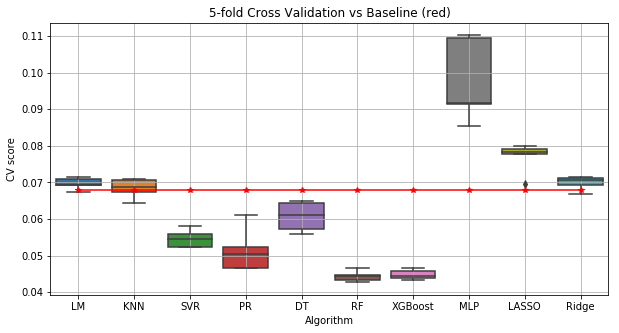

In [0]:
short_listing_results = pd.DataFrame({"Algorithm": algos, "CV_score": cv_scores})
n_algos = short_listing_results.Algorithm.nunique()
baseline_hline = baselin_score*np.ones(n_algos)

fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(short_listing_results.Algorithm, short_listing_results.CV_score, ax = ax);
ax.set_title(f"{K}-fold Cross Validation vs Baseline (red)")
ax.set_ylabel("CV score")

plt.plot(baseline_hline, 'r*-')
ax.grid(True)

__Notes__:

This round of algorithms short-listing proves that linear models are performing worse than the baseline which is coherent with EDA (specially PCA which proves sub-market is very influent feature).

### Fine-Tuning

In this section, we will be fine-tuning the top 3 promising models:
    - SVR (including polynomial kernel)
    - Random Forrest
    - XGBoost Trees

#### SVR

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Hyper-parameters distributions
hp_distribs = {'kernel': ['linear', 'rbf', 'poly'],
               'degree':[2,3,4],
               'C': reciprocal(20, 200000),
               'gamma': expon(scale=1.0),
               "epsilon":reciprocal(20, 200000)}

svm_reg = SVR()
rnd_search_svr = RandomizedSearchCV(svm_reg, param_distributions=hp_distribs,
                                n_iter=100, cv=K, scoring='neg_mean_squared_error',
                                verbose=3, n_jobs=-1, random_state=42)
rnd_search_svr.fit(X, log_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 318 out of 500 | elapsed:    1.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe321266358>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe321266898>, 'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe321266b70>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [0]:
tuned_svr = rnd_search_svr.best_estimator_
tuned_svr

SVR(C=23.098066248442485, cache_size=200, coef0=0.0, degree=2,
  epsilon=24547.601975705915, gamma=0.22153944050588595, kernel='poly',
  max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### Random Forrest

In [0]:
from scipy.stats import randint, uniform

# Hyper-parameters distributions
hp_distribs = {'n_estimators': [5,10,50,100,200, 500],
               'max_depth': randint(1,10),
               'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]}
    
rf_reg = RandomForestRegressor()
rnd_search_rf = RandomizedSearchCV(rf_reg, param_distributions=hp_distribs,
                                n_iter=100, cv=K, scoring='neg_mean_squared_error',
                                verbose=3, n_jobs=-1, random_state=42)
rnd_search_rf.fit(X, log_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [5, 10, 50, 100, 200, 500], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3467dec18>, 'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [0]:
tuned_rf = rnd_search_rf.best_estimator_
tuned_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### XGBoost Trees

In [0]:
# Hyper-parameters distributions
hp_distribs = {'max_depth': randint(1,10),
               'gamma': expon(scale=1.0),
               'n_estimators':[5,10,50,100,200, 500]}

xgb_reg = XGBRegressor()
rnd_search_xgb = RandomizedSearchCV(xgb_reg, param_distributions=hp_distribs,
                              n_iter=100, cv=K, scoring='neg_mean_squared_error',
                              verbose=3, n_jobs=-1, random_state=42)
rnd_search_xgb.fit(X, log_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3467b7da0>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3467b7eb8>, 'n_estimators': [5, 10, 50, 100, 200, 500]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [0]:
tunned_xgb = rnd_search_xgb.best_estimator_
tunned_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.00923960561099441, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### Final comparison

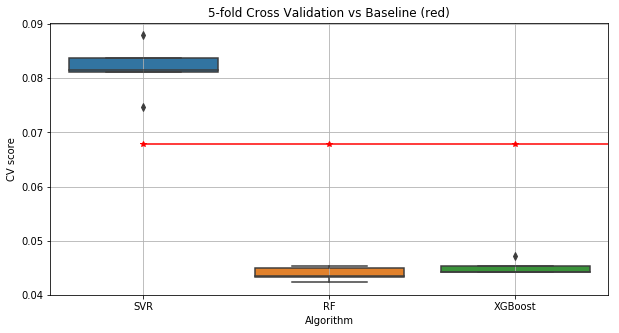

In [0]:
promising_models = {"SVR": tuned_svr, "RF": tuned_rf, "XGBoost":tunned_xgb}
algos = []
cv_scores = []
test_scores = []

for model_name in promising_models:
    
    model = promising_models[model_name]
    scores = cross_val_score(model,X,log_y,scoring="neg_mean_squared_error",cv=K)
    algos.extend([model_name]*K)
    cv_scores.extend(np.sqrt(-scores))
    

promising_models_results = pd.DataFrame({"Algorithm": algos, "CV_score": cv_scores})
n_algos = short_listing_results.Algorithm.nunique()
baseline_hline = baselin_score*np.ones(n_algos)

fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(promising_models_results.Algorithm, promising_models_results.CV_score, ax = ax);
ax.set_title(f"{K}-fold Cross Validation vs Baseline (red)")
ax.set_ylabel("CV score")

plt.plot(baseline_hline, 'r*-')
ax.grid(True)

Conclusion: ___The best models to be selected are RandomForrest.___

### Model interpretability: Features Importance

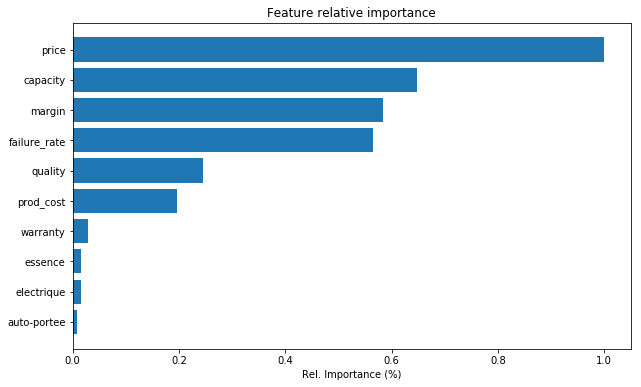

In [0]:
final_model = promising_models["RF"]

def plot_features_relative_importance(model, feat_names):
    """
    Plot features importance for decision tree based models
    """
    feat_imp = pd.Series(model.feature_importances_, index = feat_names)
    max_imp = feat_imp.max()
    rel_feat_imp = feat_imp/max_imp
    rel_feat_imp_sorted = rel_feat_imp.sort_values(ascending=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(rel_feat_imp_sorted.index,rel_feat_imp_sorted.values)
    ax.set_title("Feature relative importance")
    ax.set_xlabel("Rel. Importance (%)")
    
plot_features_relative_importance(final_model, train_prep.columns)

## Final submission

#### Training the selected model on all training set

In [0]:
raw_mower_data_train = get_data(PATH,TRAIN_FILE_NAME)
train = pre_process(raw_mower_data_train)
y = train.attractiveness.values
log_y = np.log(y + 1)
X = pre_process_pipeline.fit_transform(train.drop('attractiveness', axis = 1))
final_model.fit(X, log_y)
preds = get_preds(final_model.predict(X))
best_model_score = get_score(preds,y)
print(f"The best model score is {np.round(best_model_score,6)}")
print(f"The baseline model score is {np.round(baselin_score,6)}")

The best model score is 0.027154
The baseline model score is 0.067949


#### Making predictions for submission set

In [0]:
raw_mower_data_test = get_data(PATH,TEST_FILE_NAME)
test = pre_process(raw_mower_data_test)
X = pre_process_pipeline.fit_transform(test)
final_model.predict(X)
preds = get_preds(final_model.predict(X))

submissions = pd.DataFrame({"attractiveness": preds}, index = raw_mower_data_test.id)
file_name = "HAMMAMI_Chihebeddine_attractiveness.csv"
submissions.to_csv(os.path.join(".","..", "data",file_name))

Merci pour avoir proposé ce beau challenge et lu mon travail jusqu'à la fin :)

## External ressources
- Principal Components Analysis: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
- SciPy documentation: https://docs.scipy.org/doc/scipy/reference/index.html
- XGBoost documentation https://xgboost.readthedocs.io/

## Looking further

I had more time, I would definetly try the following ideas:

- ML
    - Feature selection using step wise selection or regularisation with LASSO
    - Uncertainty quantification: predicting attractiveness with its confidence interval
    - Ensemble the top 3 models with optimal weights
    - Explore more model interpretability with LIME and Shapely
- Developpement:
    - Produce a docker file to reproduce my entire pipeline from raw data  to predictions